In [1]:
data_dir = "C:/Users/elev/Documents/machine learning/CNN Flowers"
train_path = data_dir + "/flowers"

In [2]:
import cv2, os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augment = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.RandomRotation((0, 180)),
    transforms.RandomPerspective(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ResNet34; input 224x224
# ResNet20; input 32x32
img_size = 32

aug_data = []
data = []
labels = []

classes = {}

for dirnum, dirname in enumerate(os.listdir(train_path)):
    for filename in os.listdir(os.path.join(train_path, dirname)):
        file_path = os.path.join(train_path, dirname, filename)
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        

        data.append(transform(img_rgb))
        aug_data.append(augment(img_rgb))
        labels.append(dirnum)
    
    classes[dirnum] = dirname

def translate_label(y, translation=classes):
    return pd.series(y).apply(lambda y: translation[int(y)]).values

c:\users\elev\appdata\local\programs\python\python39\lib\site-packages\torchvision\transforms\functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ..\aten\src\ATen\LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


In [3]:
from sklearn.model_selection import train_test_split
import torch

x_train, x_test, aug_train, _, y_train, y_test = train_test_split(
    torch.stack(data),
    torch.stack(aug_data),
    torch.Tensor(labels).long(),
    test_size=0.1,
    random_state=10
)

x_train = torch.cat((x_train, aug_train), dim=0)
y_train = torch.cat((y_train, y_train), dim=0)

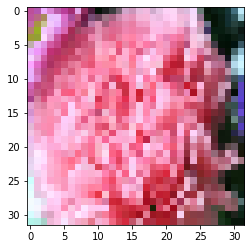

In [4]:
import numpy as np
from random import randint

def show_image(image):
    tensor = image.unsqueeze_(0)
    image = np.squeeze(tensor.numpy())
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = image.transpose((1, 2, 0))
    plt.imshow(image)

index = randint(0, len(x_test)-1)
show_image(x_train[index])

In [5]:
for i in range(len(classes)):
    print(classes[i], int((y_train == i).float().sum()))

astilbe 1344
bellflower 1560
black_eyed_susan 1826
calendula 1770
california_poppy 1824
carnation 1648
common_daisy 1738
coreopsis 1884
daffodil 1774
dandelion 1878
iris 1868
magnolia 1874
rose 1820
sunflower 1852
tulip 1896
water_lily 1776


In [6]:
import torch.nn as nn

def conv3x3(inplanes, planes, stride=1):
    return nn.Conv2d(
        in_channels=inplanes,
        out_channels=planes,
        kernel_size=(3, 3),
        stride=stride,
        padding=1,
        bias=False,
    )

def conv1x1(inplanes, planes, stride=1):
    return nn.Conv2d(
        in_channels=inplanes,
        out_channels=planes,
        kernel_size=(1, 1),
        stride=stride,
        padding=0,
        bias=False,
    )

class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        return self.relu(out)

In [7]:
import torch.nn as nn

class ResNet20(nn.Module):
    def __init__(self, num_classes):
        super(ResNet20, self).__init__()
        
        self.convolution_1 = nn.Sequential(
            conv3x3(3, 16),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        self.convolutional_layer_1 = self.make_layer(16, 16, 3, 1)
        self.convolutional_layer_2 = self.make_layer(16, 32, 3, 2)
        self.convolutional_layer_3 = self.make_layer(32, 64, 3, 2)    
        
        self.avgPool2d = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.linear = nn.Linear(4*4*64, num_classes)
        
    def forward(self, x):
        # Start Convolutional Layers
        x = self.convolution_1(x)
        x = self.convolutional_layer_1(x)
        x = self.convolutional_layer_2(x)
        x = self.convolutional_layer_3(x)
        x = self.avgPool2d(x)
        
        # Flatten input
        x = torch.flatten(x, 1)
        
        # Start Neural Network
        x = self.linear(x)
        return x
    
    def make_layer(self, inplanes, planes, blocks, stride=1):
        layer = []
        downsample = None
        
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride=stride),
                nn.BatchNorm2d(planes),
            )
        
        # Add first block
        layer.append(BasicBlock(inplanes, planes, stride, downsample))
        
        # Add the rest of the blocks
        for _ in range(1, blocks):
            layer.append(BasicBlock(planes, planes))
            
        return nn.Sequential(*layer)

model = ResNet20(len(classes))

In [8]:
import torch.nn as nn

class ResNet34(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()
        
        self.convolution_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=1)
        )
        
        self.convolutional_layer_1 = self.make_layer(64, 64, 3, 1)
        self.convolutional_layer_2 = self.make_layer(64, 128, 3, 2)
        self.convolutional_layer_3 = self.make_layer(128, 256, 3, 2)
        self.convolutional_layer_4 = self.make_layer(256, 512, 3, 2)
        
        self.avgPool2d = nn.AvgPool2d(kernel_size=(4,4), stride=2, padding=0)
        self.linear = nn.Linear(2*2*512, num_classes)
        
    def forward(self, x):
        # Start Convolutional Layers
        x = self.convolution_1(x)
        x = self.convolutional_layer_1(x)
        x = self.convolutional_layer_2(x)
        x = self.convolutional_layer_3(x)
        x = self.convolutional_layer_4(x)
        x = self.avgPool2d(x)
        
        # Flatten input
        x = torch.flatten(x, 1)
        
        # Start Neural Network
        x = self.linear(x)
        return x
    
    def make_layer(self, inplanes, planes, blocks, stride=1):
        layer = []
        downsample = None
        
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride=stride),
                nn.BatchNorm2d(planes),
            )
        
        # Add first layer
        layer.append(BasicBlock(inplanes, planes, stride, downsample))
        
        # Add the rest of the layers
        for _ in range(1, blocks):
            layer.append(BasicBlock(planes, planes))
            
        return nn.Sequential(*layer)

model = ResNet34(len(classes))

In [8]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias != None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [10]:
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss()

model.load_state_dict(torch.load("ResNet20_Augmented.pt"))

<All keys matched successfully>

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [12]:
import json
def load_file(load=True, filename="model_score"):
    try:
        if load:
            with open(filename +'.json', 'r') as f:
                return json.load(f)
    except:
        pass
    
    return {
        'Batch-Size': batch_size,
        'Epochs': 0,
        'Train-Accuracy': [],
        'Test-Accuracy': [],
        'Loss': [],
    }

def save_file(score, filename="model_score"):
    json_object = json.dumps(score, indent = 4)
    with open(filename + ".json", "w") as file:
        file.write(json_object)

In [13]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

trainset = TensorDataset(x_train, y_train)
testset = TensorDataset(x_test, y_test)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, shuffle=True)

In [14]:
score = load_file(True, "model_score_augmented")
score['Batch-Size'] = batch_size

In [16]:
model.train()
iterations = 1

for epoch in range(iterations):
    
    correct = 0.0
    running_loss = 0.0
    
    try:
        for i, (x_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            y_batch_pred = model(x_batch)
            loss = criterion(y_batch_pred, y_batch)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = y_batch_pred.max(dim = 1)[1]
            correct += (preds == y_batch).float().sum()

        epoch_loss = float(running_loss / i)
        train_acc = float(100 * correct / len(trainset))
        
        with torch.no_grad():
            y_test_pred = model(x_test)
            preds = y_test_pred.max(dim = 1)[1]
            test_acc = float(100 * (preds == y_test).float().sum() / len(y_test))
        
        score['Train-Accuracy'].append(train_acc)
        score['Test-Accuracy'].append(test_acc)
        score['Loss'].append(epoch_loss)
        score['Epochs'] += 1

        print('Epoch [%d/%d] Loss: %.4f Train-Accuracy: %.3f Test-Accuracy: %.3f' % (epoch+1, iterations, epoch_loss, train_acc, test_acc))
    except KeyboardInterrupt:
        break

Epoch [1/1] Loss: 0.7777 Train-Accuracy: 73.369 Test-Accuracy: 65.438


In [17]:
save_file(score, "model_score_augmented")

In [18]:
# Calculate class accuracies
with torch.no_grad():
    output = model(x_test)
    preds = output.max(dim = 1)[1]

    test_acc = (preds == y_test)
    for key, value in classes.items():
        c = (test_acc * (y_test == key)).float().sum()
        class_acc = float(100 * c / (y_test == key).float().sum())
        print('%s: %.3f' % (value, class_acc))
    
    print("Total Accuracy score: {0:.3f}%".format(test_acc.float().sum()/len(test_acc)*100))

astilbe: 73.846
bellflower: 54.839
black_eyed_susan: 86.207
calendula: 51.613
california_poppy: 50.909
carnation: 27.273
common_daisy: 69.369
coreopsis: 61.905
daffodil: 78.313
dandelion: 74.336
iris: 77.500
magnolia: 58.559
rose: 65.169
sunflower: 90.099
tulip: 74.000
water_lily: 56.383
Total Accuracy score: 65.438%


Image of a common_daisy predicted to 74.771% of class common_daisy
Image of a common_daisy predicted to 93.901% of class common_daisy
Image of a magnolia predicted to 37.751% of class astilbe


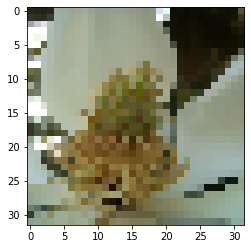

In [19]:
from random import randint

def predict_image(tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(tensor)
        prob = outputs.softmax(1)
        return prob.topk(1, dim = 1, largest=True)

def predict_random_image(amount=1):
    for i in range(amount):
        
        index = randint(0, len(x_test))
        tensor = x_test[index].unsqueeze_(0)
        y = y_test[index]

        top_p, top_class = predict_image(tensor)
        
        print("Image of a {} predicted to {}% of class {}".format(
            classes[y.item()],
            str(round(top_p.item()*100, 3)),
            classes[top_class.item()]
        ))
        show_image(tensor)
        
predict_random_image(3)

In [21]:
torch.save(model.state_dict(), "ResNet20_Augmented.pt")

Text(0, 0.5, 'Loss')

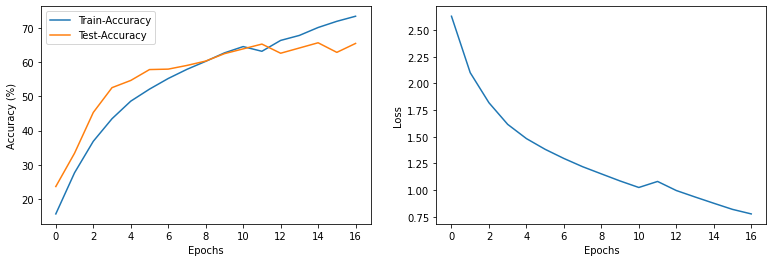

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

x = [i for i in range(score["Epochs"])]
axs[0].plot(x, score["Train-Accuracy"], label="Train-Accuracy")
axs[0].plot(x, score["Test-Accuracy"], label="Test-Accuracy")
#axs[0].title("Accuracy after 25 epochs")
axs[0].legend()
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(x, score["Loss"])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")